In [0]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import urllib.request
from progressbar import *
import socket
import os
import shutil
import cv2
import dlib
from PIL import Image
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.layers import Dropout, Input, Concatenate, concatenate
from keras import models
from keras.models import Model, load_model
from keras import backend as K
from collections import defaultdict

# Reading data

[FaceScrub dataset link](http://vintage.winklerbros.net/facescrub.html "FaceScrub")   

<img align="left" width="580" height="200" src="http://vintage.winklerbros.net/Images/facescrub.jpg">   

In [0]:
base_dir = "/content/drive/My Drive/Colab/Roonyx/Face recognition"

f = open(base_dir + "/faceScrub/facescrub_actors.txt", 'r')
actors = []
for line in f:
    actor_info = line.split('\t')
    actors.append([actor_info[0], actor_info[3]])
actors = np.array(actors)
f.close()

f = open(base_dir + "/faceScrub/facescrub_actresses.txt", 'r')
actresses = []
for line in f:
    actresses_info = line.split('\t')
    actresses.append([actresses_info[0], actresses_info[3]])
actresses = np.array(actresses)
f.close()

## Example of data

In [0]:
pd.DataFrame(data=actors[1:11], columns=actors[0])

,name,url
0,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
1,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...
2,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
3,Aaron Eckhart,http://25.media.tumblr.com/nJ2vga5sae9o2ks4Flt...
4,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
5,Aaron Eckhart,http://media.zenfs.com/en_us/Movies/PhotoG/2nd...
6,Aaron Eckhart,http://img2.timeinc.net/people/i/2008/news/080...
7,Aaron Eckhart,http://latimesblogs.latimes.com/photos/uncateg...
8,Aaron Eckhart,http://collider.com/wp-content/uploads/Aaron-E...
9,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...


## Dataset info

In [48]:
names_actors = unique_labels(actors[1:,0])
names_actresses = unique_labels(actresses[1:,0])

print("Num images: ", len(actors) + len(actresses) - 2)
print("Num images with actors: ", len(actors) - 1)
print("Num images with actresses: ", len(actresses) - 1)
print("Num actors:", len(names_actors))
print("Num actresses:", len(names_actresses))

Num images:  106863
Num images with actors:  55306
Num images with actresses:  51557
Num actors: 265
Num actresses: 265


## Download images

In [0]:
folder_for_actors = base_dir + "/faceScrub/actors_images"
# !mkdir '$folder_for_actors'
folder_for_actresses = base_dir + "/faceScrub/actresses_images"
# !mkdir '$folder_for_actresses'

In [0]:
def download(index_start, index_stop, sex='male'):

  def url_is_alive(url):
    try:
        urllib.request.urlopen(url)
        return True
    except Exception:
        return False

  if sex == "male":
    peoples = actors
  elif sex == "female":
    peoples = actresses
  else: 
    return None

  pbar = ProgressBar(maxval=index_stop-index_start)
  pbar.start()
  socket.setdefaulttimeout(5)

  # Download images
  progress = 0
  for image_id in range(index_start,index_stop,1):
    href = peoples[image_id,1]
    if(url_is_alive(href)):
      try:
        if sex == 'female':
          urllib.request.urlretrieve(href,folder_for_actresses+"/{}.jpg".format(image_id+len(actors)-1))
        else:  urllib.request.urlretrieve(href, folder_for_actors+"/{}.jpg".format(image_id))
      except Exception: pass
    pbar.update(progress)
    progress+=1
        
  pbar.finish()

In [0]:
download(1,10000,"male")

100% (9999 of 9999) |####################| Elapsed Time: 3:57:58 Time:  3:57:58


In [0]:
download(10000,20000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:42:45 Time:  1:42:45


In [0]:
download(20000,30000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:47:03 Time:  1:47:03


In [0]:
download(30000,40000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:43:21 Time:  1:43:21


In [0]:
download(40000,55306,"male")

100% (15306 of 15306) |##################| Elapsed Time: 4:41:44 Time:  4:41:44


In [0]:
download(1,10000,"female")

100% (9999 of 9999) |####################| Elapsed Time: 2:13:33 Time:  2:13:33


In [0]:
download(10000,20000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:58:13 Time:  1:58:13


In [0]:
download(20000,30000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:38:27 Time:  1:38:27


In [0]:
download(30000,40000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 3:57:18 Time:  3:57:18


In [0]:
download(40000,51557,"female")

100% (11557 of 11557) |##################| Elapsed Time: 2:22:22 Time:  2:22:22


In [0]:
print("Num downloaded images:", len(os.listdir(folder_for_actors))+len(os.listdir(folder_for_actresses)))

Num downloaded images: 57198


## Searching broken images

In [0]:
folder_for_bad_actors = base_dir + "/faceScrub/actors_bad_images"
# !mkdir '$folder_for_bad_actors'
folder_for_bad_actresses = base_dir + "/faceScrub/actresses_bad_images"
# !mkdir '$folder_for_bad_actresses'

In [0]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actors+"/{}.jpg".format(actors_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actors+"/{}.jpg".format(actors_files_names[i]),
                  folder_for_bad_actors+"/{}.jpg".format(actors_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (29804 of 29804) |##################| Elapsed Time: 2:07:42 Time:  2:07:42


In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]),
                  folder_for_bad_actresses+"/{}.jpg".format(actresses_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (27394 of 27394) |##################| Elapsed Time: 2:59:52 Time:  2:59:52


In [0]:
print("Num broken images: ", len(os.listdir(folder_for_bad_actors)) + len(os.listdir(folder_for_bad_actresses)))
print("Num good images: ", len(os.listdir(folder_for_actors)) + len(os.listdir(folder_for_actresses)))

Num broken images:  7486
Num good images:  49712


## Crope faces on images

In [0]:
folder_for_croped_images = base_dir + "/faceScrub/croped_images"
# !mkdir '$folder_for_croped_images'
folder_for_croped_actors = folder_for_croped_images + "/croped_actors"
# !mkdir '$folder_for_croped_actors'
folder_for_croped_actresses = folder_for_croped_images + "/croped_actresses"
# !mkdir '$folder_for_croped_actresses'

In [0]:
def find_face_rectangle(image_path):
  image = io.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  detector = dlib.get_frontal_face_detector()
  face_rects = detector(image, 1)
  left, right, bottom, top = 0,0,0,0
  for i, d in enumerate(face_rects):
    if i==0:
      left = d.left()
      top = d.top()
      right = d.right()
      bottom = d.bottom()
  if left==0 and top==0 and right==0 and bottom==0:
    return None
  if i>0:
    return None
  else: 
    return left, top, right, bottom

In [0]:
def crop_and_save(image_path, left, top, right, bottom, sex):
  img = Image.open(image_path)
  img = img.convert("RGB")
  croped_image = img.crop((left,top,right,bottom))
  croped_image = croped_image.resize((128, 128)) 
  if sex == "male":
    croped_image.save(folder_for_croped_actors + "/" + image_path.split("/")[-1])
  elif sex == "female":
    croped_image.save(folder_for_croped_actresses + "/" + image_path.split("/")[-1])

In [0]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  try:
    image_path = folder_for_actors + "/" + actors_files_names[i]
    croped_image_path = folder_for_croped_actors + "/" + actors_files_names[i]
    if(find_face_rectangle(image_path)) !=None:
      left, top, right, bottom = find_face_rectangle(image_path)
      crop_and_save(image_path, left, top, right, bottom, "male")
  except Exception: pass
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (26309 of 26309) |##################| Elapsed Time: 1:26:37 Time:  1:26:37


In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  try:
    image_path = folder_for_actresses + "/" + actresses_files_names[i]
    croped_image_path = folder_for_croped_actresses + "/" + actresses_files_names[i]
    if(find_face_rectangle(image_path)) !=None:
      left, top, right, bottom = find_face_rectangle(image_path)
      crop_and_save(image_path, left, top, right, bottom, "female")
  except Exception: pass
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (23403 of 23403) |##################| Elapsed Time: 2:11:19 Time:  2:11:19


In [0]:
num_croped_actors = len(os.listdir(folder_for_croped_actors))
num_croped_actresses = len(os.listdir(folder_for_croped_actresses))
print("Num images with detected actors faces: ", num_croped_actors)
print("Num images with detected actresses faces: ", num_croped_actresses)

Num images with detected actors faces:  18494
Num images with detected actresses faces:  20723


In [0]:
num_images_before_cropping = len(os.listdir(folder_for_actors)) + len(os.listdir(folder_for_actresses))
print("Num images without detected faces: ", num_images_before_cropping - num_croped_actors - num_croped_actresses)
print("Num all images with detected faces: ", num_croped_actors + num_croped_actresses)

Num images without detected faces:  10495
Num all images with detected faces:  39217


## Save metadata

In [0]:
folder_for_metadata = base_dir + "/faceScrub/metadata"
# !mkdir '$folder_for_metadata'

In [0]:
actors_files_names = os.listdir(folder_for_croped_actors)
actresses_files_names = os.listdir(folder_for_croped_actresses)
names_all = np.append(names_actors, names_actresses)
names_all = np.array(names_all)
metadata = []

for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  name_id = np.where(names_all == actors[actors_files_names[i]][0])[0][0]
  metadata.append([actors_files_names[i], name_id, actors[actors_files_names[i]][0], "male"])

for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  id_in_actresses = actresses_files_names[i]-(len(actors)-1)
  name_id = np.where(names_all == actresses[id_in_actresses][0])[0][0]
  metadata.append([actresses_files_names[i], name_id,
                   actresses[actresses_files_names[i]-(len(actors)-1)][0], "female"])

metadata = np.array(metadata)
np.savez(folder_for_metadata +'/metadata', metadata=metadata)
np.savez(folder_for_metadata + '/names_all', names_all=names_all)

In [0]:
pd.DataFrame(data=metadata[:10], columns=["image_id", "person_id", "name", "sex"])

,image_id,person_id,name,sex
0,20518,97,Gary Oldman,male
1,30100,146,Jesse Eisenberg,male
2,30101,146,Jesse Eisenberg,male
3,20520,97,Gary Oldman,male
4,20521,97,Gary Oldman,male
5,30107,146,Jesse Eisenberg,male
6,30110,146,Jesse Eisenberg,male
7,20523,97,Gary Oldman,male
8,30112,146,Jesse Eisenberg,male
9,30113,146,Jesse Eisenberg,male


## Example preprocessing

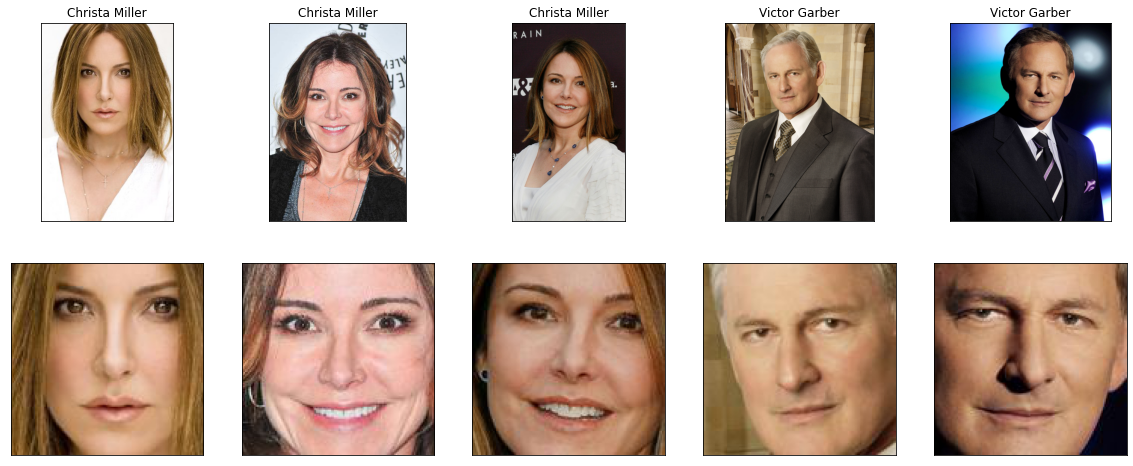

In [0]:
actresses_files_names_crop = os.listdir(folder_for_croped_actresses)
actors_files_names_crop = os.listdir(folder_for_croped_actors)
images = []
names = []

for i in range(20,23,1):
  img = io.imread(folder_for_actresses + "/" + actresses_files_names_crop[i])
  images.append(img)
  index_dot = actresses_files_names_crop[i].find('.')
  name = int(actresses_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append(metadata[id_metadata,2])

for i in range(30,32,1):
  img = io.imread(folder_for_actors + "/" + actors_files_names_crop[i])
  images.append(img)
  index_dot = actors_files_names_crop[i].find('.')
  name = int(actors_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append(metadata[id_metadata,2])

for i in range(20,23,1):
  img = io.imread(folder_for_croped_actresses + "/" + actresses_files_names_crop[i])
  images.append(img)
  index_dot = actresses_files_names_crop[i].find('.')
  name = int(actresses_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append("")

for i in range(30,32,1):
  img = io.imread(folder_for_croped_actors + "/" + actors_files_names_crop[i])
  images.append(img)
  index_dot = actors_files_names_crop[i].find('.')
  name = int(actors_files_names_crop[i][:index_dot])
  id_metadata = np.where(np.array(metadata[:,0], dtype='int64') == name)[0][0]
  names.append("")

fix,axes = plt.subplots(2,5, figsize=(20,8), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

# Neural network model

## Loss function

In [0]:
def triplet_loss(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]   
   
  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

  dist = "qeuclidean"
  margin = "maxplus"

  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
  if dist == "sqeuclidean":
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
  elif dist == "qeuclidean":
    positive_distance = tf.math.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = tf.math.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
  loss = positive_distance - negative_distance
  if margin == "maxplus":
    loss = K.maximum(0.0, 1 + loss)
  elif margin == 'softplus':
    loss = K.log(1 + K.exp(loss))

  return K.mean(loss)

## Accuracy function

In [0]:
def accuracy(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]  

  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
    
  return K.mean(positive_distance < negative_distance)

## Embedding model

In [0]:
def embedding_model_function(input_shape):
  base_input = Input(input_shape)
  x1 = layers.Conv2D(32, (3, 3), activation='relu')(base_input)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Dropout(0.25)(x1)
  x1 = layers.Conv2D(64, (3, 3), activation='relu')(x1)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Dropout(0.25)(x1)
  x1 = layers.Flatten()(x1)
  x1 = layers.Dense(2, activation='linear')(x1)
  embedding_model = Model(base_input, x1, name='embedding')

  return embedding_model

## Triplet model

In [0]:
def triplet_model_function(embedding_model_function, input_shape):
  anchor_input = Input(input_shape, name='anchor_input')
  positive_input = Input(input_shape, name='positive_input')
  negative_input = Input(input_shape, name='negative_input')
    
  anchor_embedding = embedding_model(anchor_input)
  positive_embedding = embedding_model(positive_input)
  negative_embedding = embedding_model(negative_input)

  inputs = [anchor_input, positive_input, negative_input]
  merged_vector = concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1, name='merged_layer')

  triplet_model = Model(inputs=inputs, outputs=merged_vector)
  triplet_model.add_metric(K.mean(accuracy(merged_vector, merged_vector)), "my_acc")

  return triplet_model

## Training with large (10000 images) data

### Reading data for training

In [0]:
readed = np.load(folder_for_metadata +'/metadata.npz')
metadata = readed["metadata"]
x = metadata[:,0]
x = np.array(x, dtype='int64')
y = metadata[:,1]
y = np.array(y, dtype='int64')
x = x[:10000]
y = y[:10000]

### Functions for triplets generation (faseScrub)

In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    list_labels = list(grouped.keys())
    list_labels_copy = list_labels.copy()
    for label in list_labels_copy:
      if len(grouped[label]) < 2:
        list_labels.remove(label)
    pairs = []
    for i in range(0,n,1):
        pairs.append(np.random.choice(list_labels, size=2, replace = False))
    pairs = np.array(pairs)
    positive_labels = pairs[:,0]
    negative_labels = pairs[:,1]
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    x1,x2,x3 = [],[],[]
    for i in indices[:,0]:
      if x[i] < 55309:
        x1.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x1.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,1]:
      if x[i] < 55309:
        x2.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x2.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,2]:
      if x[i] < 55309:
        x3.append(io.imread(folder_for_croped_actors + "/" + str(x[i]) + ".jpg"))
      else:
        x3.append(io.imread(folder_for_croped_actresses + "/" + str(x[i]) + ".jpg"))
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    return x1, x2, x3
    
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               np.zeros(len(x_anchor)))

### Example triplet generation

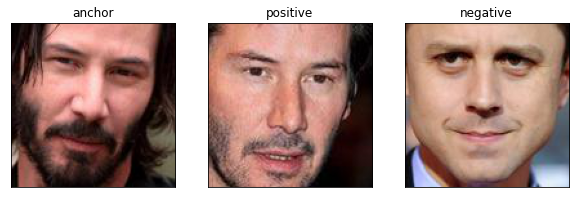

In [0]:
triplets = triplet_generator(x, y, 1)

array = []
for triplet in triplets:
  array.append(triplet)
  break

anchor = np.array(array[0][0]['anchor_input'])[0]
negative = np.array(array[0][0]['negative_input'])[0]
positive = np.array(array[0][0]['positive_input'])[0]

images = [anchor, positive, negative]
names = ["anchor", "positive", "negative"]
fix,axes = plt.subplots(1,3, figsize=(10,4), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

### Model training

In [0]:
embedding_model = embedding_model_function(input_shape = (128, 128, 3))
triplet_model = triplet_model_function(embedding_model, input_shape = (128, 128, 3))
triplet_model.compile(loss=triplet_loss, optimizer='adam')

batch_size = 10

history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                      steps_per_epoch=10,
                                      epochs=20,
                                      verbose=1)

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 41.1914 - my_acc: 0.5100
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 30.3287 - my_acc: 0.5850
Epoch 3/20
10/10 [==============================] - 10s 987ms/step - loss: 16.9510 - my_acc: 0.4950
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 11.4246 - my_acc: 0.4900
Epoch 5/20
10/10 [==============================] - 10s 974ms/step - loss: 8.2565 - my_acc: 0.4850
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 6.5485 - my_acc: 0.5150
Epoch 7/20
10/10 [==============================] - 10s 987ms/step - loss: 7.8141 - my_acc: 0.4750
Epoch 8/20
10/10 [==============================] - 10s 977ms/step - loss: 5.5558 - my_acc: 0.5300
Epoch 9/20
10/10 [==============================] - 9s 865ms/step - loss: 6.0668 - my_acc: 0.5050
Epoch 10/20
10/10 [==============================] - 8s 775ms/step - loss: 5.9339 - my_acc: 0.4950
Epoch 11/20
10/10 [

### Model loss and accuracy

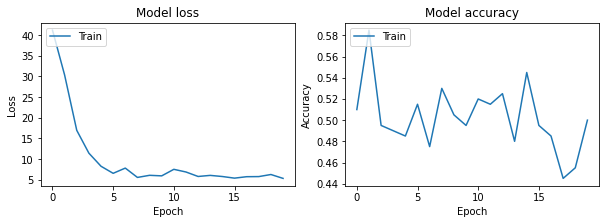

In [0]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['my_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

In [0]:
# triplet_model.save(folder_for_metadata + '/triplet.h5')
# triplet_model = load_model(folder_for_metadata + '/triplet.h5', custom_objects = {"triplet_loss": triplet_loss})

### Example of prediction

In [0]:
triplets = triplet_generator(x, y, 1)

anchor, positive, negative = [],[],[]
num = 0
for triplet in triplets:
  if num>0:
     break
  anchor.append(triplet[0]['anchor_input'][0])
  positive.append(triplet[0]['positive_input'][0])
  negative.append(triplet[0]['negative_input'][0])
  num+=1
 
anchor,positive,negative = np.array(anchor),np.array(positive),np.array(negative) 
prediction = triplet_model.predict([anchor, positive, negative])
prediction = np.array(prediction)

print("Prediction for anchor: ", prediction[0][0:2])
print("Prediction for positive: ", prediction[0][2:4])
print("Prediction for negative: ", prediction[0][4:6])

Prediction for anchor:  [-0.13249105  0.13203688]
Prediction for positive:  [-0.06245079 -0.14436242]
Prediction for negative:  [-0.662718  -1.3325919]


### Test plot embedding with 10 persons

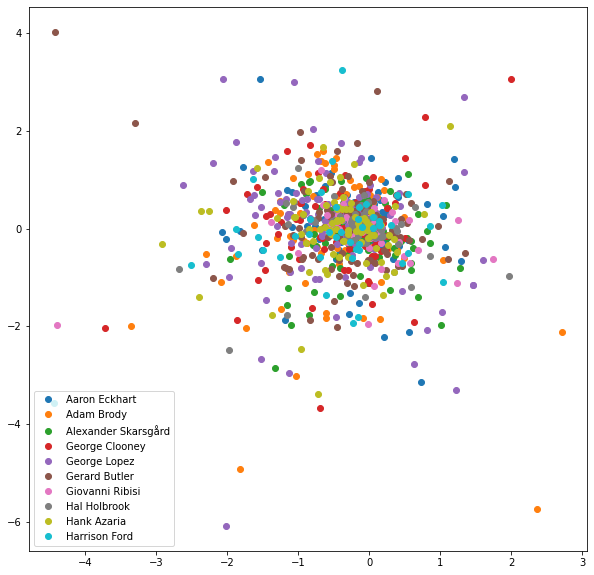

In [0]:
list_name_id = unique_labels(metadata[:,1])
plt.figure(figsize=(10,10))
for i in range(0, 10, 1):
  list_files = np.where(np.array(metadata[:,1]) == list_name_id[i])[0]
  if len(list_files)>2:
    images = []
    for j in range(0,len(list_files), 1):
      if int(metadata[list_files[j],0]) < 55309:
        images.append(io.imread(folder_for_croped_actors + "/" + str(metadata[list_files[j],0]) + ".jpg"))
      else:
        images.append(io.imread(folder_for_croped_actresses + "/" + str(metadata[list_files[j],0]) + ".jpg"))
    dots = []
    for k in range(0,len(images),1):
      dots.append(embedding_model.predict([images[k:k+1]])[0][:3])
    dots = np.array(dots)
    plt.plot(dots[:,0], dots[:,1],'o', label = metadata[list_files[j],2])
    plt.legend(loc = "best")

## Training with small (500 images) data

### Reading data for training

In [0]:
folder_croped_small = base_dir + "/faceScrub/croped_small"
files_names = os.listdir(folder_croped_small)
metadata_small = []

for i in range(0,len(files_names),1):
  index_dot = files_names[i].find('.')
  files_names[i] = int(files_names[i][:index_dot])
  if  files_names[i] < 55309:
    name_id = np.where(names_all == actors[files_names[i]][0])[0][0]
    metadata_small.append([files_names[i], name_id, actors[files_names[i]][0], "male"])
  else:
    id_in_actresses = files_names[i]-(len(actors)-1)
    name_id = np.where(names_all == actresses[id_in_actresses][0])[0][0]
    metadata_small.append([files_names[i], name_id, actresses[files_names[i]-(len(actors)-1)][0], "female"])

metadata_small = np.array(metadata_small)
# np.savez(folder_for_metadata +'/metadata_small', metadata_small=metadata_small)

In [0]:
readed = np.load(folder_for_metadata +'/metadata_small.npz')
metadata = readed["metadata_small"]
x = metadata_small[:,0]
x = np.array(x, dtype='int64')
y = metadata_small[:,1]
y = np.array(y, dtype='int64')

### Model training

In [0]:
embedding_model = embedding_model_function(input_shape = (128, 128, 3))
triplet_model = triplet_model_function(embedding_model, input_shape = (128, 128, 3))
triplet_model.compile(loss=triplet_loss, optimizer='adam')

batch_size = 10

history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                      steps_per_epoch=10,
                                      epochs=20,
                                      verbose=1)

Epoch 1/20
10/10 [==============================] - 8s 772ms/step - loss: 21.2474 - my_acc: 0.5450
Epoch 2/20
10/10 [==============================] - 9s 873ms/step - loss: 17.4986 - my_acc: 0.5400
Epoch 3/20
10/10 [==============================] - 6s 637ms/step - loss: 10.1839 - my_acc: 0.6200
Epoch 4/20
10/10 [==============================] - 6s 636ms/step - loss: 8.0424 - my_acc: 0.5550
Epoch 5/20
10/10 [==============================] - 6s 647ms/step - loss: 7.8628 - my_acc: 0.5050
Epoch 6/20
10/10 [==============================] - 6s 643ms/step - loss: 6.0331 - my_acc: 0.5300
Epoch 7/20
10/10 [==============================] - 6s 642ms/step - loss: 4.9956 - my_acc: 0.4950
Epoch 8/20
10/10 [==============================] - 6s 646ms/step - loss: 3.4175 - my_acc: 0.5750
Epoch 9/20
10/10 [==============================] - 6s 646ms/step - loss: 2.9319 - my_acc: 0.5200
Epoch 10/20
10/10 [==============================] - 6s 643ms/step - loss: 2.9225 - my_acc: 0.5400
Epoch 11/20
10/1

### Model loss and accuracy

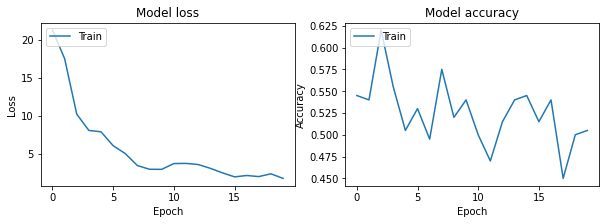

In [0]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history_small.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_small.history['my_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

### Test plot embedding with 10 persons

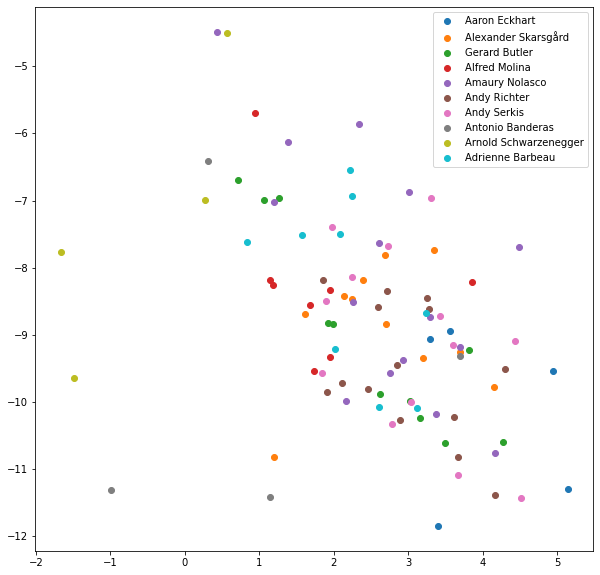

In [0]:
list_name_id = unique_labels(metadata_small[:,1])
plt.figure(figsize=(10,10))
for i in range(0, 10, 1):
  list_files = np.where(np.array(metadata_small[:,1]) == list_name_id[i])[0]
  if len(list_files)>2:
    images = []
    for j in range(0,len(list_files), 1):
      if int(metadata_small[list_files[j],0]) < 55309:
        images.append(io.imread(folder_croped_small + "/" + str(metadata_small[list_files[j],0]) + ".jpg"))
      else:
        images.append(io.imread(folder_croped_small + "/" + str(metadata_small[list_files[j],0]) + ".jpg"))
    dots = []
    for k in range(0,len(images),1):
      dots.append(embedding_model.predict([images[k:k+1]])[0])
    dots = np.array(dots)
    plt.plot(dots[:,0], dots[:,1],'o', label = metadata_small[list_files[j],2])
    plt.legend(loc = "best")

## Testing model architechure with MNIST 

### Load data from dataset

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.append(x_train, x_test, axis=0)
y = np.append(y_train, y_test, axis=0)

### Pseudo-RGB (R,G,B have the same values)

In [111]:
images = []
for i in range(0, len(x), 1):
  images.append(np.stack((x[i],x[i],x[i]), axis=2))
images = np.array(images)
x = images

print(x.shape)
print(y.shape)

(70000, 28, 28, 3)
(70000,)


### Triplets generator

In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    list_labels = list(grouped.keys())
    list_labels_copy = list_labels.copy()
    for label in list_labels_copy:
      if len(grouped[label]) < 2:
        list_labels.remove(label)
    pairs = []
    for i in range(0,n,1):
        pairs.append(np.random.choice(list_labels, size=2, replace = False))
    pairs = np.array(pairs)
    positive_labels = pairs[:,0]
    negative_labels = pairs[:,1]
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    x1,x2,x3 = [],[],[]
    for i in indices[:,0]:
      x1.append(x[i])
    for i in indices[:,1]:
      x2.append(x[i])
    for i in indices[:,2]:
      x3.append(x[i])
    x1,x2,x3 = np.array(x1), np.array(x2), np.array(x3)
    return x1, x2, x3
    
def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               np.zeros(len(x_anchor)))

### Example of triplet

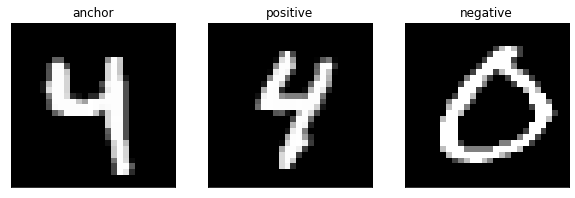

In [113]:
triplets = triplet_generator(x, y, 1)

array = []
for triplet in triplets:
  array.append(triplet)
  break

anchor = np.array(array[0][0]['anchor_input'])[0]
negative = np.array(array[0][0]['negative_input'])[0]
positive = np.array(array[0][0]['positive_input'])[0]

images = [anchor, positive, negative]
names = ["anchor", "positive", "negative"]
fix,axes = plt.subplots(1,3, figsize=(10,4), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

### Creating model

In [0]:
embedding_model = embedding_model_function(input_shape = (28, 28, 3))
triplet_model = triplet_model_function(embedding_model, input_shape = (28, 28, 3))
triplet_model.compile(loss=triplet_loss, optimizer='adam')

### Ploting embeddings before training

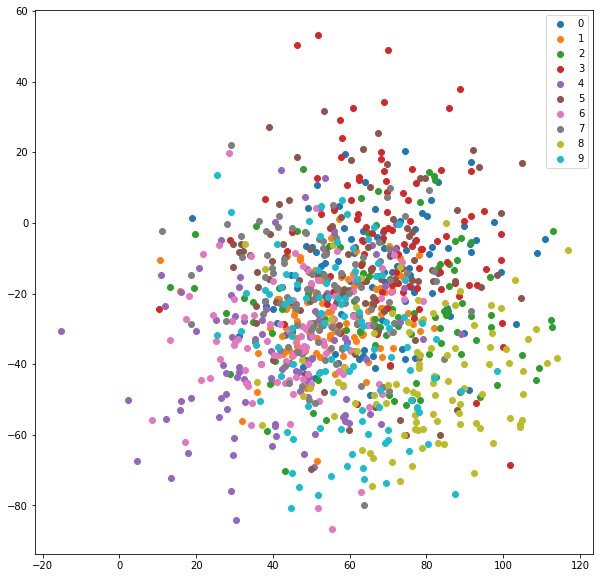

In [127]:
from sklearn.utils.multiclass import unique_labels

list_name_id = unique_labels(y)

plt.figure(figsize=(10,10))
for i in range(0, len(list_name_id), 1):
  list_files = np.where(y == list_name_id[i])[0]
  images = []
  for j in range(0,100, 1):
    images.append(x[list_files[j]])
  dots = []
  for k in range(0,len(images),1):
    dots.append(embedding_model.predict([images[k:k+1]])[0])
  dots = np.array(dots)
  plt.plot(dots[:,0], dots[:,1],'o', label = list_name_id[i])
  plt.legend(loc = "best")

### Model training

In [128]:
batch_size = 10

history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                      steps_per_epoch=10,
                                      epochs=100,
                                      verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 80ms/step - loss: 21.2905 - my_acc: 0.5150
Epoch 2/100
10/10 [==============================] - 0s 39ms/step - loss: 15.0487 - my_acc: 0.5100
Epoch 3/100
10/10 [==============================] - 0s 38ms/step - loss: 14.4950 - my_acc: 0.5400
Epoch 4/100
10/10 [==============================] - 0s 38ms/step - loss: 12.6562 - my_acc: 0.5300
Epoch 5/100
10/10 [==============================] - 0s 38ms/step - loss: 14.8273 - my_acc: 0.5600
Epoch 6/100
10/10 [==============================] - 0s 38ms/step - loss: 11.2316 - my_acc: 0.5500
Epoch 7/100
10/10 [==============================] - 0s 38ms/step - loss: 7.8447 - my_acc: 0.6100
Epoch 8/100
10/10 [==============================] - 0s 37ms/step - loss: 8.6499 - my_acc: 0.6200
Epoch 9/100
10/10 [==============================] - 0s 39ms/step - loss: 6.5808 - my_acc: 0.6350
Epoch 10/100
10/10 [==============================] - 0s 38ms/step - loss: 5.6947 - my_acc: 0.6900
Epoch 11/100


### Model loss and accuracy

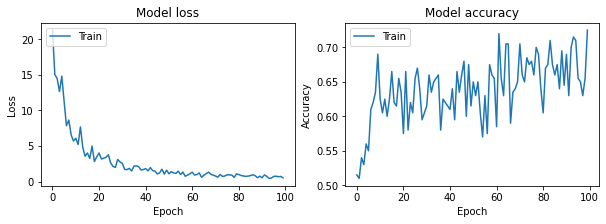

In [129]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['my_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

### Plotting embeddings after training

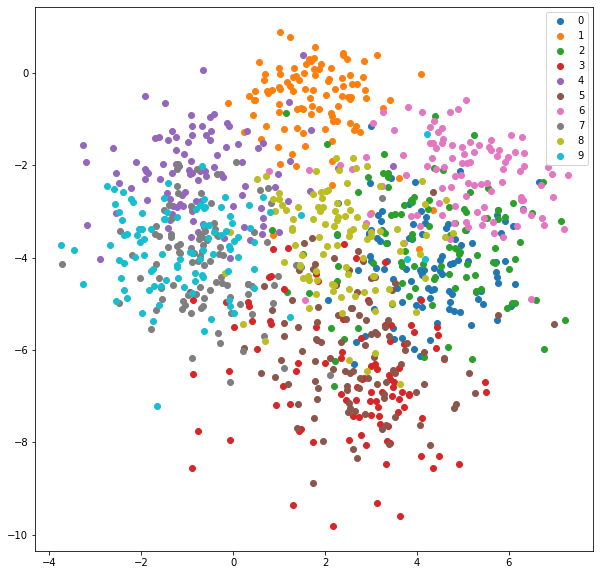

In [131]:
from sklearn.utils.multiclass import unique_labels

list_name_id = unique_labels(y)

plt.figure(figsize=(10,10))
for i in range(0, len(list_name_id), 1):
  list_files = np.where(y == list_name_id[i])[0]
  images = []
  for j in range(0,100, 1):
    images.append(x[list_files[j]])
  dots = []
  for k in range(0,len(images),1):
    dots.append(embedding_model.predict([images[k:k+1]])[0])
  dots = np.array(dots)
  plt.plot(dots[:,0], dots[:,1],'o', label = list_name_id[i])
  plt.legend(loc = "best")